# History

- 평가 지표 : MAE, RMSE, SMAPE

[참조 링크](https://www.kaggle.com/code/cdeotte/gru-model-3rd-place-gold#Train-GRU)

# Library

In [1]:

# ----- Basic setup ----- #
import pandas as pd
import numpy as np
from os.path import join as opj
from tqdm.auto import tqdm
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# pd.options.display.float_format = '{:.5f}'.format
# pd.options.display.max_rows = None

# 교육자료
# np.set_printoptions(precision=6, suppress=True)

# pd.options.display.float_format = '{:.5f}'.format
# pd.reset_option('display.float_format')

# import random
# import os
# from tqdm.notebook import tqdm

# ----- scikit learn ----- #
# from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # GroupKFold
# r2_score를 제외한 나머지 평가지표들은 클수록 안 좋고, 1보다 큰 값도 왕왕 등장합니다.
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder
# -1 ~ 1 사이, 0~1사이로 값의 단위를 고정시켜줍니다. : 정규화

# R2 score : 1 - sum((y_true - y_pred) ** 2) / sum((y_true - y_true.mean())**2)
# 1에 가까울 수록 좋은 모델, 0에 가까울 수록 나쁨, 음수가 나오면 잘못 평가 되었음을 의미합니다.

# ----- tensorflow & keras ----- #

from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator # https://github.com/keras-team/keras/blob/cdffff886626e5a05bc5d54b8a4634f1e5db06cf/keras/preprocessing/sequence.py#L56
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow as tf


# ----- visualization ----- #
import matplotlib.pyplot as plt
import seaborn as sns

# import plotly.express as px
# import plotly.graph_objects as go
# import plotly.figure_factory as ff
# from plotly.subplots import make_subplots
# from plotly.offline import init_notebook_mode, iplot


# yahoo financial, unofficial way, rate limit
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

# Configuration

In [2]:
%%writefile config.yml

# 주석은 값에서 띄어쓰기를 꼭해줘야 한다. (yaml의 특성이 아닌 Namespace의 특성일 수도 있다.)
base:
  exp_name: exp_01
  task_name: asset # asset or portfolio
  model_name: GRU # LSTM, xgboost
  use_gpu: false
  index_name: ^BSESN # ^BVSP : 브라질,  ^TWII : 대만, ^BSESN : 인도
  seed: 813
  base_dir: /content/ # /drive/MyDrive/~~~
  output_dir: ./
  #log_file: train_log.log

data:
  lookback_window: 10 #  look back period 5 21 42
  lookahead_window: 62 # 5 3개월 후로 고정되어 있으므로... 62는 장 개장일 기준으로 3개월 후한 첫 번째 값의 간격. 즉 17.01.02-> 17.04.03 사이에 62개
  y_form: ratio # value #

train:
  #dataset:
  start_date: 2017-01-01
  end_date: 2020-12-31
  use_derive_vairable: true

valid:
  #dataset:
  start_date: 2021-01-01
  end_date: 2021-12-31
  use_derive_vairable: true

test:
  #dataset:
  start_date: 2022-01-01
  end_date: 2022-12-31

Overwriting config.yml


In [3]:
import yaml
# pyyaml docs : https://pyyaml.org/wiki/PyYAMLDocumentation
from types import SimpleNamespace
# Ref : https://github.com/ybabakhin/kaggle-feedback-effectiveness-1st-place-solution/blob/main/train.py
# Ref : https://github.com/ybabakhin/kaggle-feedback-effectiveness-1st-place-solution/blob/main/yaml/awesome-rose-ff.yaml

# 예시로 살펴볼 수 있는 하나의 yaml 파일 : https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.6/configs/cls/cls_mv3.yml

cfg = yaml.safe_load(open("/content/config.yml").read())
for k, v in cfg.items():
    if type(v) == dict:
        cfg[k] = SimpleNamespace(**v)
cfg = SimpleNamespace(**cfg)
# logger(cfg)
print(cfg)

# config_file = "config.yml"
# with open(config_file) as f:

#     cfg = yaml.load(f, Loader=yaml.FullLoader)

# print(cfg)

namespace(base=namespace(exp_name='exp_01', task_name='asset', model_name='GRU', use_gpu=False, index_name='^BSESN', seed=813, base_dir='/content/', output_dir='./'), data=namespace(lookback_window=10, lookahead_window=62, y_form='ratio'), train=namespace(start_date=datetime.date(2017, 1, 1), end_date=datetime.date(2020, 12, 31), use_derive_vairable=True), valid=namespace(start_date=datetime.date(2021, 1, 1), end_date=datetime.date(2021, 12, 31), use_derive_vairable=True), test=namespace(start_date=datetime.date(2022, 1, 1), end_date=datetime.date(2022, 12, 31)))


# Utilities

In [4]:
import logging
from os.path import join as opj
# cfg_base로 바꾸기
def get_logger(cfg_global):

    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    handler1 = logging.StreamHandler()
    handler1.setFormatter(logging.Formatter("%(message)s")) # 시간을 넣어줘야겠어..
    handler2 = logging.FileHandler(filename=opj(cfg_global.output_dir, f"{cfg_global.task_name}_{cfg_global.model_name}_{cfg_global.exp_name}.log"))
    handler2.setFormatter(logging.Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger(cfg.base)

# Data Generation

In [5]:
def make_data(df, cfg_data, return_to_df=False):

    # change into uncommented code (delete "+1" in -1 axis of df.iloc). caused by  IndexError: index 1230 is out of bounds for axis 0 with size 1230
    # total_sample_num = df.iloc[cfg_data.lookback_window-1:-cfg_data.lookahead_window+1].shape[0]
    total_sample_num = df.iloc[cfg_data.lookback_window-1:-cfg_data.lookahead_window].shape[0]

    #  특징 하나
    fea_num = df.columns.get_loc("Close")

    x_data = np.zeros((total_sample_num, cfg_data.lookback_window))
    y_data = np.zeros((total_sample_num, 1))

    end_date = cfg_data.lookback_window-1

    for idx in tqdm(range(total_sample_num)):

        x_data[idx,] = df.iloc[idx:idx+cfg_data.lookback_window, fea_num].values

        # 반복 효율을 위해 a로 변환 가능 [a는 for문 밖으로]
        # a = end_date+cfg_data.lookahead_window
        # y_data[idx,] = df.iloc[idx+a, fea_num]/df.iloc[idx+end_date, fea_num]
        y_data[idx,] = df.iloc[idx+end_date+cfg_data.lookahead_window, fea_num]/df.iloc[idx+end_date, fea_num]-1

    # pd.DataFrame(y_data).describe()

    if return_to_df:
        pass
        # FEATURES = [f'f{x}' for x in range(WIDTH-COPIES-4-1)]
        # TARGETS = [f'y{x}' for x in range(5)]
        # train_data = pd.DataFrame(x_data3,columns=FEATURES)
        # train_data[TARGETS] = y_data3
        # train_data['cfips'] = np.repeat(KEEP,COPIES)
        # print('Our GRU training data has shape:', train_data.shape )
        # train_data.head()
    else:
        return x_data, y_data



# Model

In [8]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU  (docs)
# Ref : https://www.kaggle.com/code/cdeotte/gru-model-3rd-place-gold?scriptVersionId=133950942&cellId=35
def build_model(cfg):

    inp = tf.keras.Input(shape=(cfg.data.lookback_window,1)) # INPUT SHAPE IS 12

    assert cfg.base.model_name in ['GRU', 'LSTM'], "check model_name"

    RNN = getattr(layers, cfg.base.model_name)
    x = RNN(units=8, return_sequences=True)(inp)
    x = RNN(units=8, return_sequences=True)(x)
    x = RNN(units=8, return_sequences=False)(x)
    x = layers.Dense(1,activation='linear')(x) # OUTPUT SHAPE IS 5
    model = tf.keras.Model(inputs=inp, outputs=x)

    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(loss=loss, optimizer = opt)

    return model

# Metric

In [9]:
# np.sqrt(sum((y_true - y_pred)**2)  / len(y_pred))
def rmse(y_true, y_pred):
    # sklearn.metrics 패키지에는 별도의 RMSE 평가지표는 없습니다
    return np.sqrt(mean_squared_error(y_true, y_pred))


# Ref : https://www.kaggle.com/code/cdeotte/gru-model-3rd-place-gold?scriptVersionId=133950942&cellId=40
def smape(y_true, y_pred):

    # CONVERT TO NUMPY
    y_true = np.array(y_true.flatten())
    y_pred = np.array(y_pred.flatten())

    # WHEN BOTH EQUAL ZERO, METRIC IS ZERO
    both = np.abs(y_true) + np.abs(y_pred)
    idx = np.where(both==0)[0]
    y_true[idx]=1; y_pred[idx]=1

    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Run

학습까지만 진행하는 Run 부분

In [10]:
################################# GRU (similar with LSTM) #################################

### 데이터 받아오기
train = pdr.get_data_yahoo(cfg.base.index_name, cfg.train.start_date, cfg.train.end_date).reset_index()
valid = pdr.get_data_yahoo(cfg.base.index_name, cfg.valid.start_date, cfg.valid.end_date).reset_index()
# test = pdr.get_data_yahoo(cfg.base.index_name, cfg.test.start_date, cfg.test.end_date).reset_index()

logger.info(f"train data start date : {train.Date.min()} end date : {train.Date.max()}")

### EDA

# train.query("Volume<10") Volume이 0인 경우 확인 필요
# label은 Scaling 안하는 것인가? Close


# FIRST DAY, LAST DAY
# train.first_day_of_month.min(), train.first_day_of_month.max()

### 학습 데이터 생성
x_data, y_data = make_data(train, cfg.data)
logger.info(f"!!Train data infoi!! \n  x_data.shape : {x_data.shape} \t y_data.shape : {y_data.shape}")


### STANDARIZE
mn = np.mean(x_data)
sd = np.std(x_data)
x_data = (x_data - mn)/sd
# y_data = (y_data - mn)/sd
logger.info(f"Average ratio =,{mn},and Average std =, {sd}")

X_train, X_valid, y_train, y_valid = train_test_split(x_data, y_data, shuffle=True,random_state=cfg.base.seed, test_size=0.2)

### 모델
model = build_model(cfg)
logger.info(model.summary())

### 학습
h = model.fit(X_train,y_train,
                validation_data = (X_valid,y_valid),
                # sample_weight = np.tile(w,GRP),
                batch_size=4, epochs=10, verbose=2)

### 모델 저장
cfg_global = cfg.base
model.save_weights(f"{cfg_global.task_name}_{cfg_global.model_name}_{cfg_global.exp_name}.h5")
# model.load_weights(INFER_FROM_PATH + f'GRU_f{fold}_v{VER}.h5')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

train data start date : 2017-01-02 00:00:00 end date : 2020-12-30 00:00:00
INFO:__main__:train data start date : 2017-01-02 00:00:00 end date : 2020-12-30 00:00:00


  0%|          | 0/912 [00:00<?, ?it/s]

!!Train data infoi!! 
  x_data.shape : (912, 10) 	 y_data.shape : (912, 1)
INFO:__main__:!!Train data infoi!! 
  x_data.shape : (912, 10) 	 y_data.shape : (912, 1)
Average ratio =,35160.52655007881,and Average std =, 3598.430798942858
INFO:__main__:Average ratio =,35160.52655007881,and Average std =, 3598.430798942858


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 gru (GRU)                   (None, 10, 8)             264       
                                                                 
 gru_1 (GRU)                 (None, 10, 8)             432       
                                                                 
 gru_2 (GRU)                 (None, 8)                 432       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 1,137
Trainable params: 1,137
Non-trainable params: 0
_________________________________________________________________


None
INFO:__main__:None


Epoch 1/10
183/183 - 12s - loss: 0.0078 - val_loss: 0.0080 - 12s/epoch - 68ms/step
Epoch 2/10
183/183 - 3s - loss: 0.0072 - val_loss: 0.0078 - 3s/epoch - 17ms/step
Epoch 3/10
183/183 - 4s - loss: 0.0071 - val_loss: 0.0076 - 4s/epoch - 19ms/step
Epoch 4/10
183/183 - 4s - loss: 0.0069 - val_loss: 0.0075 - 4s/epoch - 23ms/step
Epoch 5/10
183/183 - 6s - loss: 0.0068 - val_loss: 0.0074 - 6s/epoch - 31ms/step
Epoch 6/10
183/183 - 6s - loss: 0.0067 - val_loss: 0.0072 - 6s/epoch - 34ms/step
Epoch 7/10
183/183 - 5s - loss: 0.0066 - val_loss: 0.0071 - 5s/epoch - 26ms/step
Epoch 8/10
183/183 - 4s - loss: 0.0065 - val_loss: 0.0070 - 4s/epoch - 24ms/step
Epoch 9/10
183/183 - 5s - loss: 0.0065 - val_loss: 0.0070 - 5s/epoch - 28ms/step
Epoch 10/10
183/183 - 3s - loss: 0.0064 - val_loss: 0.0068 - 3s/epoch - 17ms/step


In [17]:
################################# LSTM #################################
cfg.base.model_name = "LSTM"

### 데이터 받아오기
train = pdr.get_data_yahoo(cfg.base.index_name, cfg.train.start_date, cfg.train.end_date).reset_index()
valid = pdr.get_data_yahoo(cfg.base.index_name, cfg.valid.start_date, cfg.valid.end_date).reset_index()
# test = pdr.get_data_yahoo(cfg.base.index_name, cfg.test.start_date, cfg.test.end_date).reset_index()

logger.info(f"train data start date : {train.Date.min()} end date : {train.Date.max()}")

### EDA

# train.query("Volume<10") Volume이 0인 경우 확인 필요
# label은 Scaling 안하는 것인가? Close


# FIRST DAY, LAST DAY
# train.first_day_of_month.min(), train.first_day_of_month.max()

### 학습 데이터 생성
x_data, y_data = make_data(train, cfg.data)
logger.info(f"!!Train data infoi!! \n  x_data.shape : {x_data.shape} \t y_data.shape : {y_data.shape}")


### STANDARIZE
mn = np.mean(x_data)
sd = np.std(x_data)
x_data = (x_data - mn)/sd
# y_data = (y_data - mn)/sd
logger.info(f"Average ratio =,{mn},and Average std =, {sd}")

X_train, X_valid, y_train, y_valid = train_test_split(x_data, y_data, shuffle=True,random_state=cfg.base.seed, test_size=0.2)

### 모델
model = build_model(cfg)
logger.info(model.summary())

### 학습
h = model.fit(X_train,y_train,
                validation_data = (X_valid,y_valid),
                # sample_weight = np.tile(w,GRP),
                batch_size=4, epochs=10, verbose=2)

### 모델 저장
cfg_global = cfg.base
model.save_weights(f"{cfg_global.task_name}_{cfg_global.model_name}_{cfg_global.exp_name}.h5")
# model.load_weights(INFER_FROM_PATH + f'GRU_f{fold}_v{VER}.h5')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

train data start date : 2017-01-02 00:00:00 end date : 2020-12-30 00:00:00
INFO:__main__:train data start date : 2017-01-02 00:00:00 end date : 2020-12-30 00:00:00


  0%|          | 0/912 [00:00<?, ?it/s]

!!Train data infoi!! 
  x_data.shape : (912, 10) 	 y_data.shape : (912, 1)
INFO:__main__:!!Train data infoi!! 
  x_data.shape : (912, 10) 	 y_data.shape : (912, 1)
Average ratio =,35160.52655007881,and Average std =, 3598.430798942858
INFO:__main__:Average ratio =,35160.52655007881,and Average std =, 3598.430798942858


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 8)             320       
                                                                 
 lstm_1 (LSTM)               (None, 10, 8)             544       
                                                                 
 lstm_2 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,417
Trainable params: 1,417
Non-trainable params: 0
_________________________________________________________________


None
INFO:__main__:None


Epoch 1/10
183/183 - 12s - loss: 0.0075 - val_loss: 0.0078 - 12s/epoch - 65ms/step
Epoch 2/10
183/183 - 3s - loss: 0.0068 - val_loss: 0.0076 - 3s/epoch - 15ms/step
Epoch 3/10
183/183 - 4s - loss: 0.0065 - val_loss: 0.0070 - 4s/epoch - 20ms/step
Epoch 4/10
183/183 - 4s - loss: 0.0062 - val_loss: 0.0068 - 4s/epoch - 20ms/step
Epoch 5/10
183/183 - 5s - loss: 0.0060 - val_loss: 0.0065 - 5s/epoch - 26ms/step
Epoch 6/10
183/183 - 3s - loss: 0.0058 - val_loss: 0.0062 - 3s/epoch - 19ms/step
Epoch 7/10
183/183 - 4s - loss: 0.0056 - val_loss: 0.0059 - 4s/epoch - 24ms/step
Epoch 8/10
183/183 - 4s - loss: 0.0055 - val_loss: 0.0058 - 4s/epoch - 21ms/step
Epoch 9/10
183/183 - 3s - loss: 0.0053 - val_loss: 0.0056 - 3s/epoch - 15ms/step
Epoch 10/10
183/183 - 3s - loss: 0.0052 - val_loss: 0.0054 - 3s/epoch - 17ms/step


In [ ]:
# # scikit learn과 호환가능하도록 누군가가 커스터마이징해서 올려놓은 모델 = wrapper model, wrapper module
# from xgboost import XGBRegressor
# from xgboost import plot_importance

# xgbr = XGBRegressor()
# xgbr.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', early_stopping_rounds= 110, verbose=False)
# ypred = xgbr.predict(X_test)
# score = xgbr.score(X_train, y_train)
# mse = mean_squared_error(y_test, ypred)

# print("Training score: ", score)
# print("MSE: %.2f" % mse)
# print("RMSE: %.2f" % (mse**(1/2.0)))


# Validation

In [18]:

#### 검증
x_data, y_data = make_data(valid, cfg.data)
logger.info(f"!!Valid data infoi!! \n  x_data.shape : {x_data.shape} \t y_data.shape : {y_data.shape}")
# 학습 때 활용했던 mn, sd 그대로 사용
x_data = (x_data - mn)/sd

preds = np.zeros(y_data.shape)

model = build_model(cfg)
model.load_weights(f"{cfg_global.task_name}_{cfg_global.model_name}_{cfg_global.exp_name}.h5")

preds = model.predict(x_data, verbose=2) # / FOLDS

  0%|          | 0/175 [00:00<?, ?it/s]

!!Valid data infoi!! 
  x_data.shape : (175, 10) 	 y_data.shape : (175, 1)
INFO:__main__:!!Valid data infoi!! 
  x_data.shape : (175, 10) 	 y_data.shape : (175, 1)


6/6 - 2s - 2s/epoch - 292ms/step


GRU!!

In [12]:
logger.info(f"Metric Result : MAE : {mean_absolute_error(y_data, preds)} \t RMSE : {rmse(y_data, preds)} \t SMAPE : {smape(y_data, preds)}")

Metric Result : MAE : 0.2571558175745449 	 RMSE : 0.26433578236609756 	 SMAPE : 190.3021776287268
INFO:__main__:Metric Result : MAE : 0.2571558175745449 	 RMSE : 0.26433578236609756 	 SMAPE : 190.3021776287268


LSTM!! below

In [19]:
logger.info(f"Metric Result : MAE : {mean_absolute_error(y_data, preds)} \t RMSE : {rmse(y_data, preds)} \t SMAPE : {smape(y_data, preds)}")

Metric Result : MAE : 0.5999046329918347 	 RMSE : 0.6036685215981378 	 SMAPE : 196.19140732138248
INFO:__main__:Metric Result : MAE : 0.5999046329918347 	 RMSE : 0.6036685215981378 	 SMAPE : 196.19140732138248


# Visualization

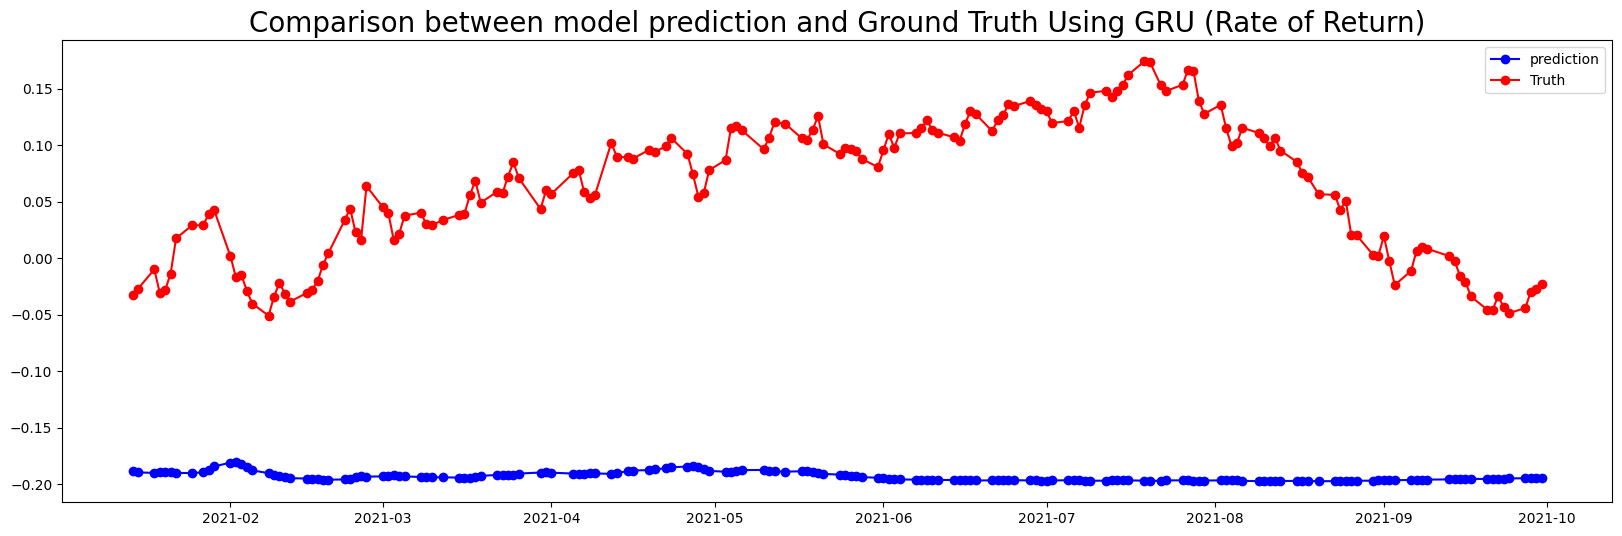

In [13]:
valid_date = valid.iloc[cfg.data.lookback_window-1:-cfg.data.lookahead_window].Date
visual_y_data = y_data.reshape(-1,)
visual_preds = preds.reshape(-1,)

plt.figure(figsize=(20,6))
plt.plot(valid_date, visual_preds, '-ob', label='prediction')
plt.plot(valid_date, visual_y_data, '-or', label='Truth')
plt.title(f'Comparison between model prediction and Ground Truth Using {cfg.base.model_name} (Rate of Return)',size=20)
plt.legend()
plt.show()

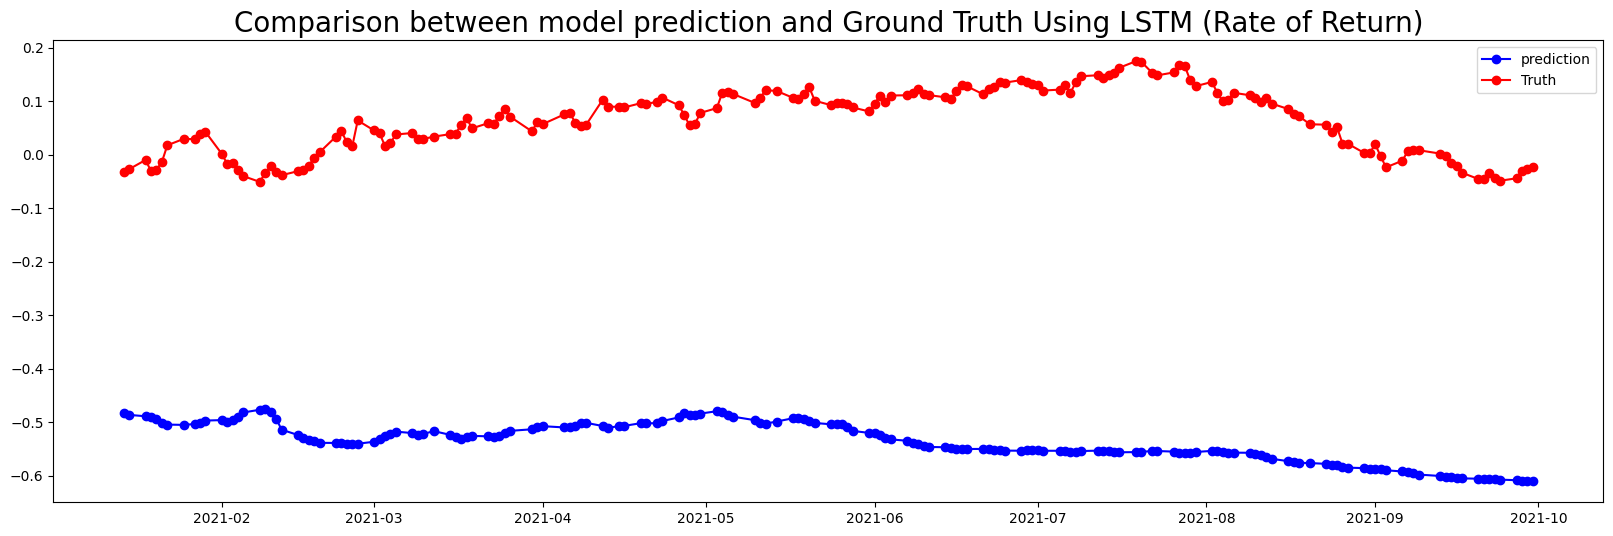

In [20]:
valid_date = valid.iloc[cfg.data.lookback_window-1:-cfg.data.lookahead_window].Date
visual_y_data = y_data.reshape(-1,)
visual_preds = preds.reshape(-1,)

plt.figure(figsize=(20,6))
plt.plot(valid_date, visual_preds, '-ob', label='prediction')
plt.plot(valid_date, visual_y_data, '-or', label='Truth')
plt.title(f'Comparison between model prediction and Ground Truth Using {cfg.base.model_name} (Rate of Return)',size=20)
plt.legend()
plt.show()

# Future Work

- 수익률 값이 애초에 너무 작기에 Loss가 제대로 먹히지 않는 느낌이다. 해결책은 찾아보자.
- Feature를 추가해본다.
- 교차검증을 시도한다.
- Model hyperparameter를 조정해본다.